In [1]:
import pertpy as pt
import scanpy as sc
import pandas as pd

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

In [2]:
adata = pt.dt.dialogue_example()
adata

AnnData object with n_obs × n_vars = 5374 × 6329
    obs: 'nCount_RNA', 'nFeature_RNA', 'cellQ', 'gender', 'location', 'clinical.status', 'cell.subtypes', 'pathology', 'origin', 'subset'
    var: 'name'

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

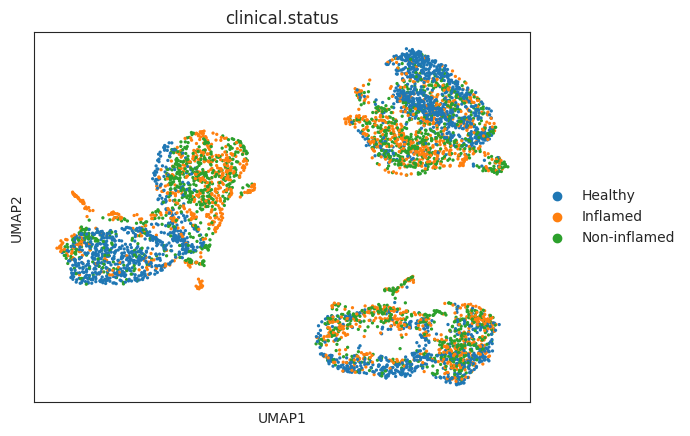

In [4]:
sc.pl.umap(
    adata,
    color=[
        "clinical.status"
    ],
)

In [5]:
dl = pt.tl.Dialogue()

In [6]:
adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
    adata,
    groupby='clinical.status',
    celltype_key='cell.subtypes',
    mimic_dialogue=True
)

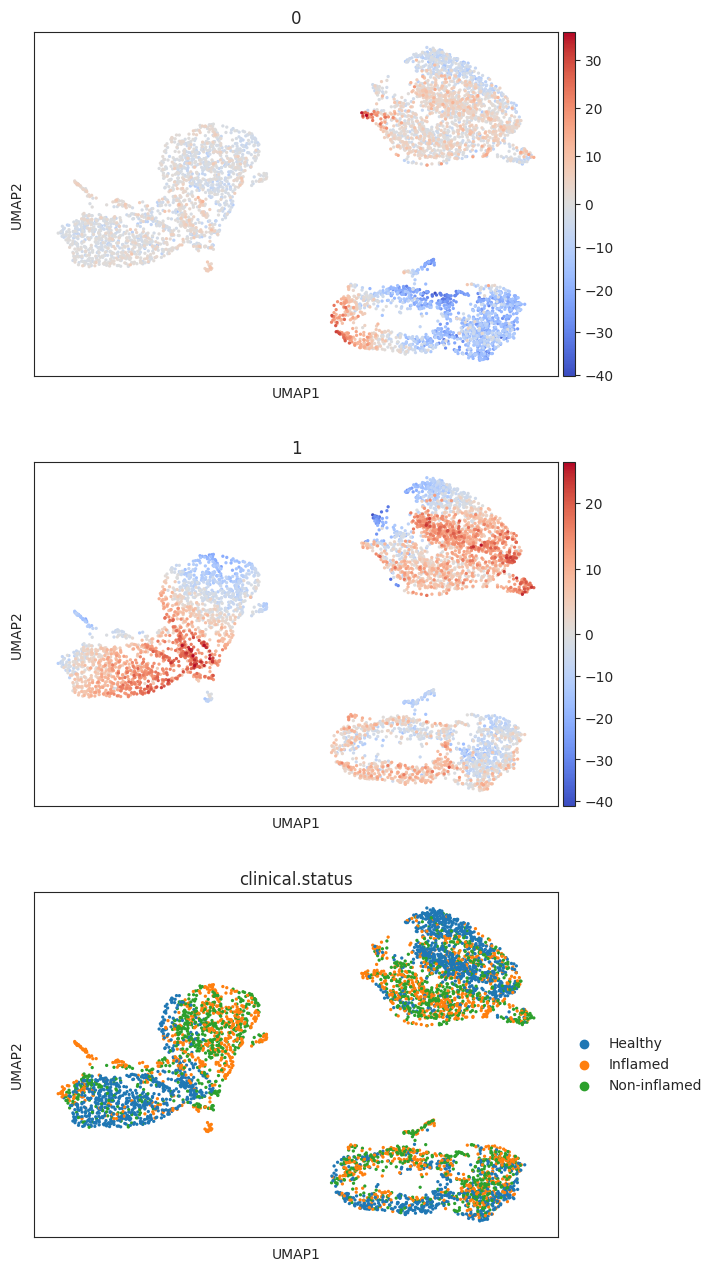

In [7]:
sc.pl.umap(adata, color=[0, 1, 'clinical.status'], ncols=1, cmap='coolwarm', vcenter=0)